In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
gameweek = 32

In [3]:
# Initialize an empty list to store all individual, player gameweek data 
all_player_sep = []

# Loop through each gameweek
for i in range(1, gameweek + 1):  # Adjusting the range to start from 1 to gameweek
    # Read the CSV for the current gameweek
    x = pd.read_csv(rf'C:\Users\thoma\Code\Projects\Fantasy-Premier-League\Data\2024_25\Players\Seperate_GW\GW_{i}.csv')

    # Append the current gameweek data to the list
    all_player_sep.append(x)

# Concatenate all dataframes in the list into a single dataframe
player_data = pd.concat(all_player_sep, axis=0, ignore_index=True)

# Drop unnamed column
player_data = player_data.drop(columns = ['Unnamed: 0'])

In [4]:
player_data.columns

Index(['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today',
       'GW Points', 'Minutes', 'KO_time', 'Goals', 'Assists', 'Clean Sheets',
       'Goals Conceded', 'Penalties Saved', 'Penalties Missed', 'YC', 'RC',
       'Saves', 'Total Bonus Points', 'Total BPS', 'Influence', 'Creativity',
       'Threat', 'ICT Index', 'xG', 'xA', 'xGi', 'xGc', 'Transfers In GW',
       'Transfers Out GW', 'Gameweek', 'Opponent', 'Difficulty', 'Avail'],
      dtype='object')

In [5]:
# Sort dataset by Player ID and Gameweek
final_data = player_data.sort_values(by=['Player ID', 'Gameweek'])

# Define the rolling window size
number_of_games = 4

# Calculate the rolling average of GW_Points over the specified number_of_games
final_data["Form"] = (
    final_data
    .groupby("Player ID")["GW Points"]
    .transform(lambda x: x.rolling(window=number_of_games).mean().round(3))
)

In [6]:
# Choose important columns
columns = [
    'Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today',
    'GW Points', 'Form', 'Gameweek',
]

# Create final dataset
final_data = final_data[columns]

# Add fixture list into spreadsheet
fixtures = pd.read_csv(r'C:\Users\thoma\Code\Projects\Fantasy-Premier-League\Data\2024_25\Fixtures\Schedule\Fixtures.csv')

# Merge on fixture list
final_data = final_data.merge(fixtures, on= 'Team')

In [7]:
# Add opponent information
final_data["Opponent"] = final_data.apply(
    lambda row: row[f"GW{row['Gameweek']}"], axis=1
)

In [8]:
cols = ['Player ID', 'Name', 'Last_Name', 'Team', 'Position', 'Cost_Today',
       'GW Points', 'Form', 'Gameweek', 'Opponent']

model = final_data[cols]

In [9]:
# Import improve fixture difficulty 
difficulty = pd.read_csv(r'C:\Users\thoma\Code\Projects\Fantasy-Premier-League\Data\2024_25\Fixtures\Difficulty_ratings\FD_IMPROVED\Current_FD_Improved.csv', index_col=0)

# Create a mapping dictionary from fixture difficulty
mapping = difficulty.set_index(['Opponent', 'Position'])['FD_combined'].to_dict()

In [10]:
# Create tuple key in model
model["Difficulty"] = model.apply(
    lambda row: mapping.get((row["Opponent"], row["Position"])), axis=1
)

C:\Users\thoma\AppData\Local\Temp\ipykernel_41828\3760575110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model["Difficulty"] = model.apply(


In [11]:
# Drop nan or 0.0 values
model = model[model["Form"].notna() & (model["Form"] != 0.0)]

In [12]:
model['FD_index'] = (model['Form']/model['Difficulty'])*10

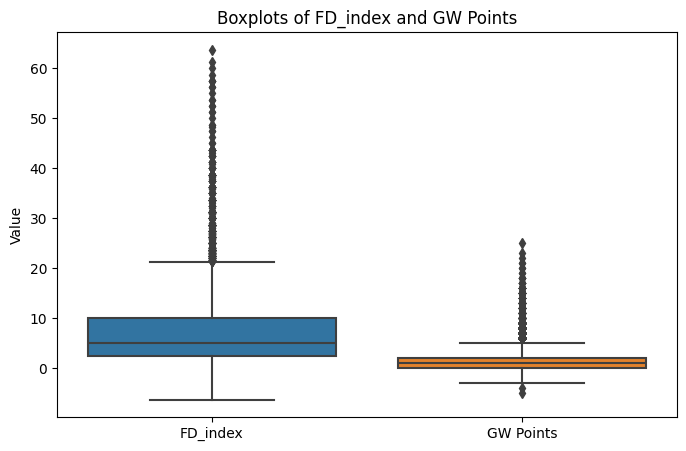

In [13]:
# View box-plots
cols = ["FD_index", "GW Points"]

plt.figure(figsize=(8, 5))
sns.boxplot(data=model[cols])
plt.title("Boxplots of FD_index and GW Points")
plt.ylabel("Value")
plt.show()

In [14]:
# Remove negative and 0 FD_index values
# REASON: We will actively choose +ve FD players and those who play and these players
# usually score at least 1 point. 
model = model[model['FD_index'] > 0]
model = model[model['GW Points'] > 0]

In [15]:
# Assess the shape of the distributions
# There is a strong positive skew for both variables, which will be pulling the mean
# up. It is better to use the median to calculate line of best fit. 

C:\Users\thoma\AppData\Local\Temp\ipykernel_41828\1802250024.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_range = np.linspace(X.min()[0], X.max()[0], 100).reshape(-1, 1)
c:\Users\thoma\anaconda3\envs\complete_ml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\thoma\anaconda3\envs\complete_ml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(


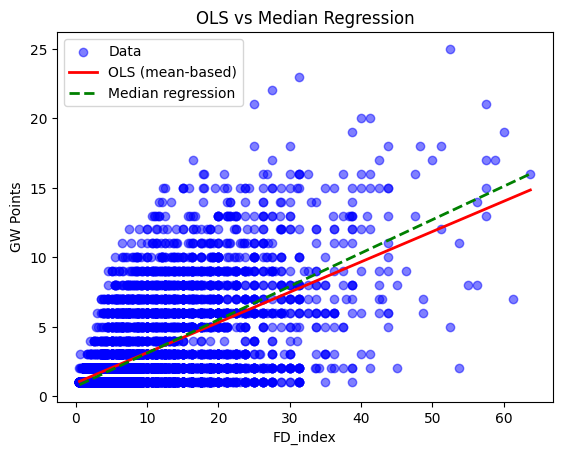

In [20]:
# Features and target
X = model[["FD_index"]]
y = model["GW Points"]

# --- Fit OLS regression ---
ols = LinearRegression()
ols.fit(X, y)

# --- Fit Median regression (quantile=0.5) ---
qr = QuantileRegressor(quantile=0.60, alpha=0)
qr.fit(X, y)

# --- Make x range for plotting ---
x_range = np.linspace(X.min()[0], X.max()[0], 100).reshape(-1, 1)

# Predictions
y_ols = ols.predict(x_range)
y_qr = qr.predict(x_range)

# --- Plot ---
plt.scatter(X, y, color="blue", alpha=0.5, label="Data")
plt.plot(x_range, y_ols, color="red", linewidth=2, label="OLS (mean-based)")
plt.plot(x_range, y_qr, color="green", linewidth=2, linestyle="--", label="Median regression")

plt.xlabel("FD_index")
plt.ylabel("GW Points")
plt.title("OLS vs Median Regression")
plt.legend()
plt.show()

In [21]:
r2 = qr.score(X, y)
print(r2)

0.3421044198343235


In [ ]:
# Interesting hypertuning of the model using quantile. 
# Increasing the quantile moves the line of best fit upward -- what is the best fit? 

In [ ]:
# Why?: Error terms in a linear model should have a normal distribution (are independent)
# Why?

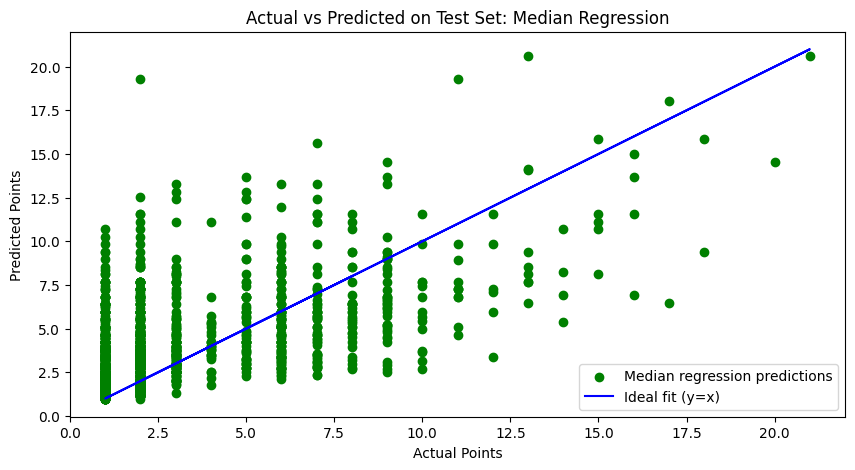

In [93]:
# --- Fit Median Regression (quantile=0.5) ---
qr = QuantileRegressor(quantile=0.75, alpha=0)
qr.fit(X_train, y_train)

# --- Predict on test set ---
y_pred_median = qr.predict(X_test)

# --- Visualize predictions ---
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_median, color="green", label="Median regression predictions")
plt.plot(y_test, y_test, color="blue", label="Ideal fit (y=x)")
plt.title("Actual vs Predicted on Test Set: Median Regression")
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.legend()
plt.show()

Text(0, 0.5, 'Standardize')

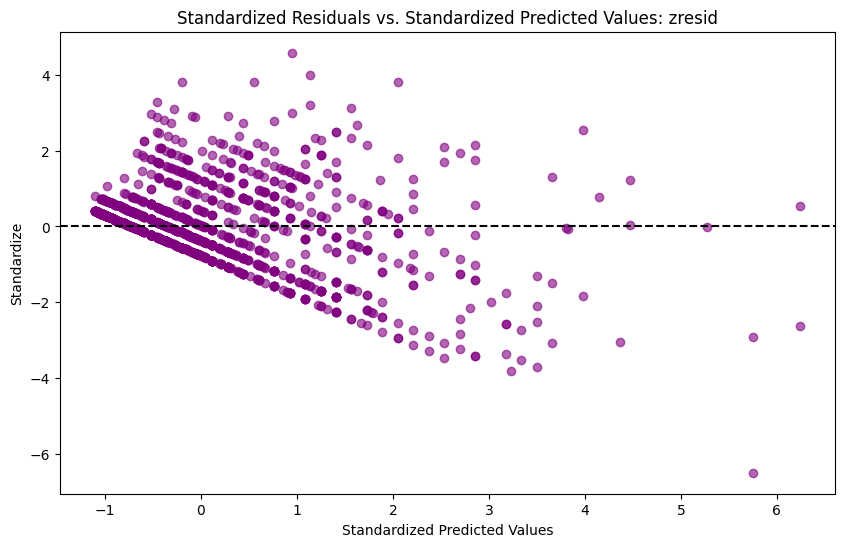

In [95]:
# Calculate residuals
residuals = y_test - y_pred_median

# Standardize the predicted values and residuals
pred_scaler = StandardScaler()
residual_scaler = StandardScaler()

# Reshape y_pred and residuals to 2D for scaling
y_pred_std = pred_scaler.fit_transform(y_pred_median.reshape(-1, 1)).flatten()
residuals_std = residual_scaler.fit_transform(residuals.values.reshape(-1, 1)).flatten()

# Plot standardized residuals vs. standardized predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_std, residuals_std, color='purple', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at 0 for reference
plt.title('Standardized Residuals vs. Standardized Predicted Values: zresid')
plt.xlabel('Standardized Predicted Values')
plt.ylabel('Standardize')

Stages of model assessment
1) Is the data any good? Is it reliable? Is it valid?
--- Key area here is fixture difficulty? Team form changes FD over time and there is nothing quantifying this (FD is static for whole season).
--- Are there other variables that could improve the model?
2) Is a linear model the best? Why? What else could improve the model?